In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from ssm import plotutils, preprocess, graphs, peaks, bravais
from ssm import Structures
from ssm.register import MatchGraph
from ssm.bravais import single_crystal_sweep, CrystalDetector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def scaled_power_spectrum(image, scale):
    
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    
    power_spectrum = np.log(1 + scale * np.abs(fft_image))
    
    return preprocess.normalize_range(power_spectrum)

In [12]:
image = Image.open('InAs-InP_20nm_559000X_21.tif')
#image = Image.open('Graphene_L1_Stelle3_0013.tif')

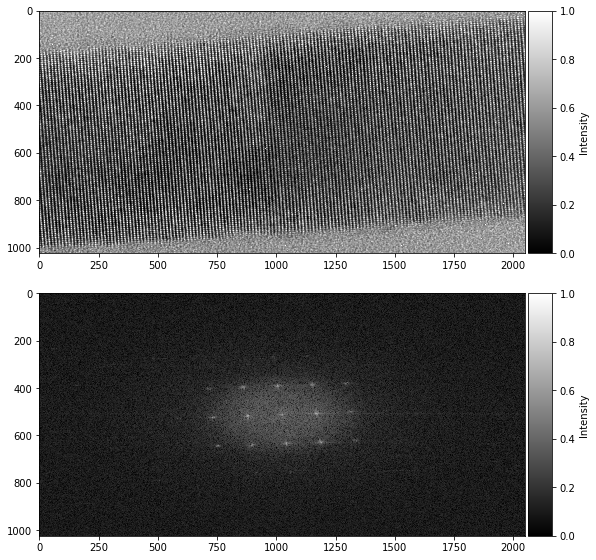

In [13]:
image = np.array(image).astype(float)

image = preprocess.normalize_range(image)

fft_image = np.fft.fftshift(np.fft.fft2(image))

power_spectrum = scaled_power_spectrum(image, .1)

fig,axes=plt.subplots(2, 1, figsize = (8, 8))
im=axes[0].imshow(image.T, cmap='gray', interpolation='nearest')
plotutils.add_colorbar(im, axes[0], label='Intensity');

im=axes[1].imshow(power_spectrum.T, cmap='gray', interpolation='nearest')
plotutils.add_colorbar(im, axes[1], label='Intensity');

plt.tight_layout()

In [52]:
rmsd_calc = MatchGraph(transform='rigid', scale_invariant=True, pivot='cop')

detector = CrystalDetector(rmsd_calc, .2)

detectors = single_crystal_sweep(power_spectrum, detector, 20, 8, step_size=1, min_sigma=1, max_sigma=20)

In [53]:
num_crystal_faces = [detector.num_crystal_faces() for detector in detectors]

best = [detector for detector in detectors if detector.num_crystal_faces() == max(num_crystal_faces)]

average_crystal_rmsd = [detector.average_crystal_rmsd() for detector in best]

best = best[average_crystal_rmsd.index(min(average_crystal_rmsd))]


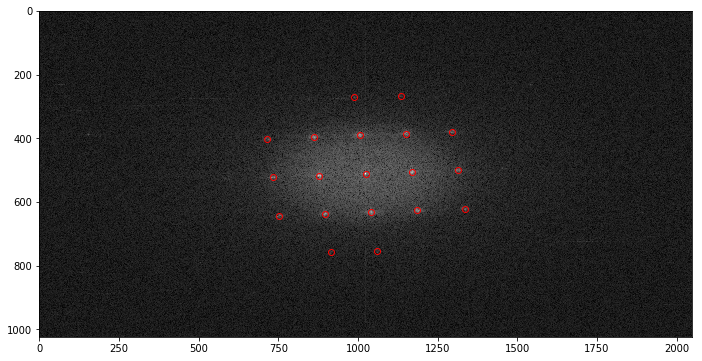

In [54]:
fig,ax=plt.subplots(1, 1, figsize = (12, 6))
im=ax.imshow(power_spectrum.T, cmap='gray', interpolation='nearest')
#plotutils.add_colorbar(im, ax, label='Intensity')
ax.plot(best.crystal_points()[:,0],best.crystal_points()[:,1], 'ro', fillstyle='none');

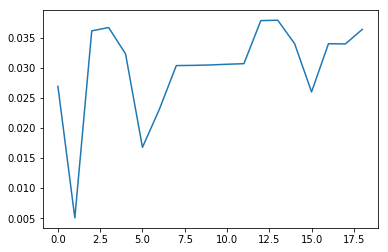

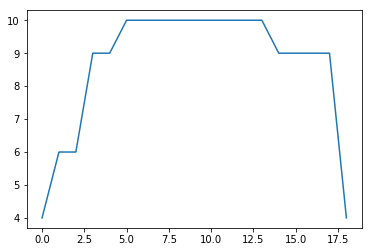

In [16]:
plt.plot([detector.average_crystal_rmsd() for detector in detectors])
plt.show()
plt.plot([detector.num_crystal_faces() for detector in detectors])


#fig,ax=plt.subplots(1, 1, figsize = (8, 4))
#im=ax.imshow(power_spectrum.T, cmap='gray', interpolation='nearest')
#plotutils.add_colorbar(im, ax, label='Intensity')
#ax.plot(points[:,0],points[:,1], 'ro', fillstyle='none');

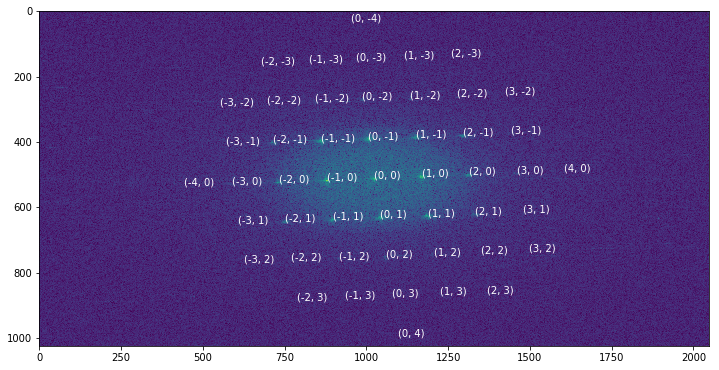

In [36]:
a,b,x0 = best.get_lattice_parameters('corners')

fig,ax=plt.subplots(figsize = (12, 12))
ax.imshow(power_spectrum.T)

max_order = 4
center = np.array(power_spectrum.shape)/2
miller = {}
for h in range(-max_order,max_order+1):
    k_max = np.sqrt(max_order**2 - h**2).astype(int)
    for k in range(-k_max, k_max+1):
        miller[(h,k)] = [h*a[0] + k*b[0] + center[0],
                         h*a[1] + k*b[1] + center[1]]

for hk,position in miller.items():
    ax.annotate('{}'.format(hk),xy=position,color='w')
